# COGS 189 Final Project

## Import libraries

In [1]:
# Display plots directly in the notebook instead of in a new window
%matplotlib inline

from sklearn import svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import torch
from torch.autograd import Variable
from torch.cuda import FloatTensor
import torch.nn.functional as F
import torch.utils.data as Data

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.ops import rnn, rnn_cell


## Data Overview

In [3]:
# read the dataset
data_df = pd.read_csv("EEG_data.csv")
data_df.shape

(12811, 15)

In [4]:
# convert to numpy array
data = data_df.to_numpy(copy=True)

In [5]:
data

array([[0.0000e+00, 0.0000e+00, 5.6000e+01, ..., 8.2930e+03, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 4.0000e+01, ..., 2.7400e+03, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 4.7000e+01, ..., 2.5354e+04, 0.0000e+00,
        0.0000e+00],
       ...,
       [9.0000e+00, 9.0000e+00, 6.0000e+01, ..., 2.0240e+03, 1.0000e+00,
        0.0000e+00],
       [9.0000e+00, 9.0000e+00, 6.0000e+01, ..., 1.7640e+03, 1.0000e+00,
        0.0000e+00],
       [9.0000e+00, 9.0000e+00, 6.4000e+01, ..., 4.4820e+03, 1.0000e+00,
        0.0000e+00]])

In [7]:
data_df

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0
5,0.0,0.0,44.0,66.0,73.0,1786446.0,176766.0,59352.0,26157.0,15054.0,33669.0,33782.0,31750.0,0.0,0.0
6,0.0,0.0,43.0,69.0,130.0,635191.0,122446.0,90107.0,65072.0,36230.0,53019.0,62938.0,59307.0,0.0,0.0
7,0.0,0.0,40.0,61.0,-2.0,161098.0,12119.0,1963.0,809.0,1277.0,3186.0,3266.0,2518.0,0.0,0.0
8,0.0,0.0,43.0,69.0,17.0,492796.0,120998.0,63697.0,68242.0,10769.0,88403.0,73756.0,22676.0,0.0,0.0
9,0.0,0.0,47.0,69.0,-59.0,82048.0,116131.0,47317.0,26197.0,41642.0,28866.0,32551.0,41810.0,0.0,0.0


## Method I: Deep Neural Network

We want to know what is the correlation between the EEG signals and the output attention. Our first method is to generate a model between signals Delta, Theta, Alpha1, Alpha2, Beta1, Beta2, Gamma1, and Gamma2. The output $y$ should be the variable attention. 

### Data Cleaning

In [8]:
# traning set X and target y should all be normalized
x = data[:, 4:13]
x = x / x.max(axis=0)
y = (data[:, 2] / (np.max(data[:, 2]) - np.min(data[:, 2])))[:, np.newaxis]

# torch can only train on Variable, so convert them to Variable
x, y = Variable(torch.from_numpy(x)), Variable(torch.from_numpy(y))


### Training

In [9]:
torch.manual_seed(1)    # reproducible

# another way to define a network
net = torch.nn.Sequential(
        torch.nn.Linear(9, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 1),
    )

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

BATCH_SIZE = 64
EPOCH = 200

torch_dataset = Data.TensorDataset(x, y)

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=0,)

# start training
net = net.float()
epoch_losses = []
for epoch in range(EPOCH):
    epoch_loss = 0
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        
        b_x = Variable(batch_x).float()
        b_y = Variable(batch_y).float()

        prediction = net(b_x)     # input x and predict based on x

        loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        
        epoch_loss += loss.item()
        
    epoch_losses.append(epoch_loss / len(loader))
#     plt.plot(epoch_losses)
    print(f"Training epoch {epoch}, epoch loss {epoch_loss / len(loader)}")

Training epoch 0, epoch loss 0.03638039692420864
Training epoch 1, epoch loss 0.03203356765970514
Training epoch 2, epoch loss 0.030110935597166197
Training epoch 3, epoch loss 0.029843101509619708
Training epoch 4, epoch loss 0.029814325977320696
Training epoch 5, epoch loss 0.02914593260346064
Training epoch 6, epoch loss 0.029950463319595774
Training epoch 7, epoch loss 0.029374975497968754
Training epoch 8, epoch loss 0.029264034953579973
Training epoch 9, epoch loss 0.029515512899231554
Training epoch 10, epoch loss 0.02879989550759395
Training epoch 11, epoch loss 0.02902671957935267
Training epoch 12, epoch loss 0.028942851641618493
Training epoch 13, epoch loss 0.02883047711067087
Training epoch 14, epoch loss 0.02878566058491593
Training epoch 15, epoch loss 0.02915058240516862
Training epoch 16, epoch loss 0.0290418669942822
Training epoch 17, epoch loss 0.028503271945710503
Training epoch 18, epoch loss 0.028371417431614886
Training epoch 19, epoch loss 0.02881095799344096
T

Training epoch 161, epoch loss 0.0258421850117359
Training epoch 162, epoch loss 0.025960520873615396
Training epoch 163, epoch loss 0.02578434050639174
Training epoch 164, epoch loss 0.027003218035273883
Training epoch 165, epoch loss 0.026204712035607047
Training epoch 166, epoch loss 0.025956435314384265
Training epoch 167, epoch loss 0.02811728962303246
Training epoch 168, epoch loss 0.027503325483432754
Training epoch 169, epoch loss 0.026251463011018376
Training epoch 170, epoch loss 0.026143904770747642
Training epoch 171, epoch loss 0.02620904706881859
Training epoch 172, epoch loss 0.026040528431784973
Training epoch 173, epoch loss 0.025927646822337783
Training epoch 174, epoch loss 0.026017105109544834
Training epoch 175, epoch loss 0.026131470826690765
Training epoch 176, epoch loss 0.025725367761666503
Training epoch 177, epoch loss 0.02786047176101166
Training epoch 178, epoch loss 0.02639379721153435
Training epoch 179, epoch loss 0.026473634880944272
Training epoch 180,

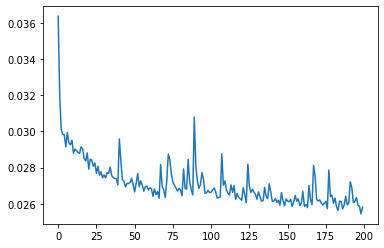

In [10]:
plt.plot(epoch_losses)

In [11]:
net(x.float()).detach().numpy()

array([[0.5547539 ],
       [0.46904352],
       [0.4978917 ],
       ...,
       [0.457706  ],
       [0.44219193],
       [0.64022213]], dtype=float32)

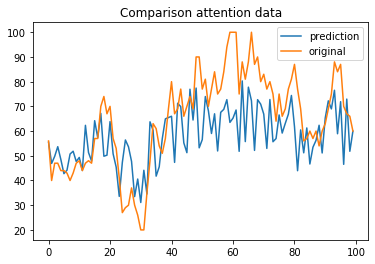

In [18]:
plt.plot(net(x.float()).detach().numpy()[0:100] * 100, label = 'prediction')
plt.plot(y.detach().numpy()[0:100] * 100, label = 'original')
plt.title("Comparison attention data")
plt.legend()

Text(0.5, 1.0, 'Given Attention data')

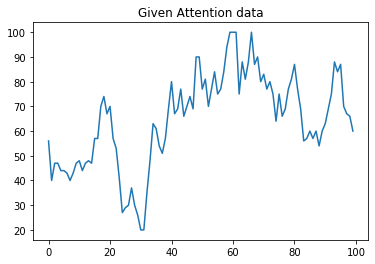

In [14]:
plt.plot(y.detach().numpy()[0:100] * 100)
plt.title("Given Attention data")

We could see by the simple neural network, our prediction is overfiting to the origin data.

# Method II: SVM

In [21]:
#normalize the data
X = data_df.iloc[:, 4:13]
y = data_df.iloc[:, 2:3]

pca = PCA()

scaler = StandardScaler()

X_sc = scaler.fit_transform(X)
X_sc_pca = pca.fit_transform(X_sc)

y_sc = scaler.fit_transform(y)

In [22]:
X_sc_pca.shape

(12811, 9)

In [23]:
regressor = svm.SVR(kernel = 'rbf', gamma = 'auto') #using support vector regressor model
regressor.fit(X_sc_pca, np.ravel(y_sc))

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [24]:
y_pred = regressor.predict(X_sc_pca)
y_pred = scaler.inverse_transform(y_pred) #inverse the scaler
df_y_pred = pd.DataFrame(y_pred)
df_y_pred.columns = ['prediction of attention']

## Compare the original data and the prediction

In [72]:
df_y_pred

,prediction of attention
0,53.680552
1,49.267012
2,46.584454
3,51.357318
4,45.644404
5,43.814122
6,28.966215
7,49.310263
8,46.620903
9,46.386432


In [74]:
df_attention = pd.DataFrame(y)
df_attention

,Attention
0,56.0
1,40.0
2,47.0
3,47.0
4,44.0
5,44.0
6,43.0
7,40.0
8,43.0
9,47.0


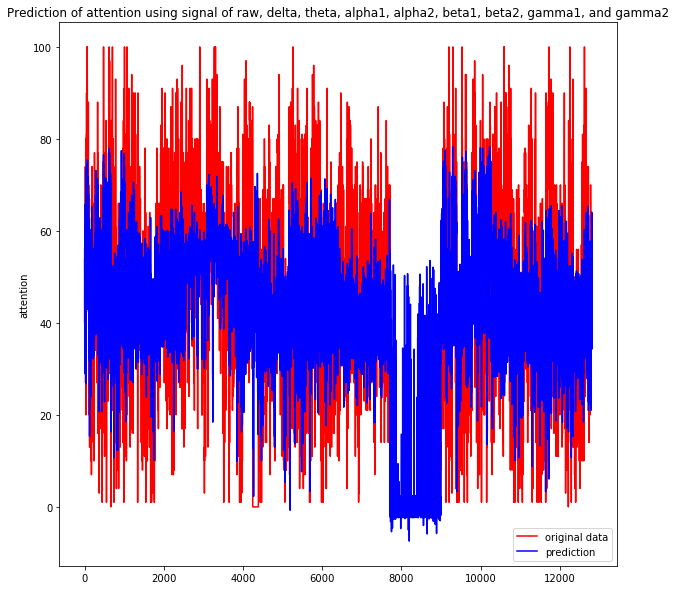

In [44]:
plt.figure(figsize=(10, 10))
plt.plot(y,color = 'red', label = 'original data')
plt.plot(y_pred,color = 'blue', label = 'prediction')
plt.ylabel('attention')
plt.legend(loc = "lower right")
plt.title('Prediction of attention using signal of raw, delta, theta, alpha1, alpha2, beta1, beta2, gamma1, and gamma2')

plt.show()

In order to have a better comparison between the original data and the prediction, we will randomly select 100 samples from both types of data

In [66]:
random_original = df_attention.sample(n = 100) #select 100 ramdom samples

index = random_original.index.to_numpy() #convert to array
ori_arr = random_original.to_numpy()

y_pred_arr = df_y_pred.to_numpy()

new_df_att = df_attention.to_numpy()

new_ori_arr = [] 
pred_arr = []

col1_ori = []
col2_ori = []
col1_pred = []
col2_pred = []

for i in range(100): #append the content of the lists
    col1_ori.append(index[i])
    col2_ori.append(ori_arr[i])
    col1_pred.append(index[i])
    col2_pred.append(y_pred_arr[index[i]])

#new plots are based on the index and the value of the attention
col1_ori = np.vstack(col1_ori)
new_ori_arr = np.hstack((col1_ori, col2_ori))
df1 = pd.DataFrame(new_ori_arr)
df1.columns = ['index', 'data']


col1_pred = np.vstack(col1_pred)
pred_arr = np.hstack((col1_pred, col2_pred))
df2 = pd.DataFrame(pred_arr)
df2.columns = ['index', 'data']

df1.sort_values(by = ['index', 'data'], inplace = True) #sort the data based on the original index
df2.sort_values(by = ['index', 'data'], inplace = True)

check = []
for i in range(len(df1.index)):
    for j in range(len(df1.columns)):
        if (df1.iloc[i,j] == df2.iloc[i,j]):
            check.append(True)

if len(check) == len(df1.index):
    print('The sorted dataframes have the same corresponding index of the data point')

The sorted dataframes have the same corresponding index of the data point


In [76]:
df1

,index,data
21,126.0,13.0
40,174.0,29.0
71,286.0,43.0
91,293.0,51.0
22,329.0,61.0
80,405.0,60.0
0,410.0,48.0
34,418.0,50.0
30,464.0,75.0
81,542.0,80.0


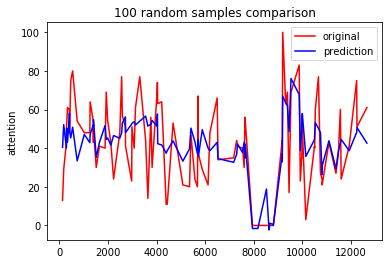

In [77]:
plt.plot(df1.iloc[:, 0], df1.iloc[:, 1], color = 'red', label = 'original')
plt.plot(df2.iloc[:, 0], df2.iloc[:, 1], color = 'blue', label = 'prediction')
plt.ylabel('attention')
plt.title('100 random samples comparison')
plt.legend()